<a href="https://colab.research.google.com/github/D-Jones25/Research/blob/main/Aptoid_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# run here #

In [ ]:
!pip install torch_geometric -q
!pip install xgboost -q
#!pip install sentence_transformers -q
!pip install shap -q

In [ ]:
import pandas as pd
import networkx as nx
import itertools
import torch
import numpy as np

import torch.nn as nn
from torch import nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv, DenseGCNConv

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
from networkx.convert import to_networkx_graph
from networkx.generators.classic import Graph
from torch_geometric.utils import to_networkx
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import xgboost as xgb
from xgboost import XGBRegressor

import requests
from bs4 import BeautifulSoup
import re

from imblearn.under_sampling import RandomUnderSampler

#import sentence_transformers
#from sentence_transformers import SentenceTransformer, models

from torch_geometric.nn import CorrectAndSmooth

import shap
from torch_geometric.explain import Explainer, GNNExplainer

from pandas.api.types import is_numeric_dtype
pd.options.display.float_format = '{:.00f}'.format

In [ ]:
def split_suggApps_string(df):
    df['suggApps'] = [test[1 : len(test)-1].replace("'", "").split(", ") for test in df['suggApps']]
    return df

In [ ]:
class Arguments:
  def __init__(self):
    self.seed = 123
    self.model_lr = 0.01
    self.weight_decay = 5e-4
    self.hidden_layers = 32
    self.dropout = 0.5
    self.ptb_rate = 0.25
    self.do_sampling = 'Y'
    self.sample_size = 500
    self.num_samples = 20
    self.ptb_epochs = 30
    self.reg_epochs = 100
args = Arguments()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Feature Building Utils

In [ ]:
def get_permissions(id):
  print(id)
  response = requests.get(id)
  if response.status_code == 200:
    # Parse the HTML content of the page
    soup = BeautifulSoup(response.text, 'html.parser')
    #downloads = soup.find('span', attrs={"class":"app-informations__AppSpan-sc-1wisk8p-6 app-informations__DetailsMainSpan-sc-1wisk8p-16 eBKTbc fNvkUS"}).contents[0]
    permissions = soup.find('script', attrs={"type":"application/json"})

    text = permissions.contents[0].split('"used_permissions":[')[1]
    permissions = [word for word in text.split(','[0]) if '.permission' in word]
    for i in range(len(permissions)):
      permissions[i] = (re.sub(r'[^\w\s\.]', '', permissions[i])).lower()

    if permissions:
      return ' '.join(permissions)
    else:
      return ''

In [ ]:
"""
    word_embedding_model = models.Transformer('bert-base-uncased')
    pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
    dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), out_features=512, activation_function=nn.Tanh())
    model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model])

    example_perms = get_permissions(df.loc[0,'_id'])
    example_tens = torch.tensor(model.encode(example_perms))
    df['permissionsEmb'] = [torch.zeros_like(example_tens)] * len(df)

"""

"\n    word_embedding_model = models.Transformer('bert-base-uncased')\n    pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())\n    dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), out_features=512, activation_function=nn.Tanh())\n    model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model])\n\n    example_perms = get_permissions(df.loc[0,'_id'])\n    example_tens = torch.tensor(model.encode(example_perms))\n    df['permissionsEmb'] = [torch.zeros_like(example_tens)] * len(df)\n\n"

In [ ]:
def transform_str_emb(emb):
  emb = ', '.join((emb.replace('[[','').replace(']]','').replace('\n','')).split())
  #emb = emb.replace(',,', ',')
  return eval(f"torch.{emb}")

In [ ]:
T_Keys = {'private_TK':'private', 'sensitive_TK':'sensitive', 'censor_TK':'censor', 'protect_TK':'protect', 'decoy_TK':'decoy', 'privacy_TK':'privacy',
          'secret_TK':"secret", 'hide_TK':'hide', 'vault_TK':'vault', 'secure_TK':'secure', 'safe_TK':'safe', 'steganography_TK':'steganography', 'fake_TK':'fake',
          'password-protected_TK':'password-protected'}

D_Keys = {'private_DK':'private', 'sensitive_DK':'sensitive', 'censor_DK':'censor', 'protect_DK':'protect', 'decoy_DK':'decoy', 'privacy_DK':'privacy', 'secret_DK':'secret', 'hide_DK':'hide',
            'vault_DK':'vault', 'secure_DK':'secure', 'safe_DK':'safe', 'photos_DK':'photos', 'videos_DK':'videos', 'notes_DK':'notes', 'password_DK':'password', 'contacts_DK':'contacts',
            'browser_DK':'browser', 'lock_DK':'lock', 'gallery_DK':'gallery', 'calculator_DK':'calculator', 'fingerprint_DK':'fingerprint', 'password-protected_DK':'password-protected', 'fake_DK':'fake',
            'steganography_DK':'steganography'}

In [ ]:
def build_keywords(df):
  val_str_dic = {'000000':'m', '000':'k'}
  df['mainContent'] = df['mainContent'].str.lower().replace(val_str_dic, regex=True)
  df['title'] = df['title'].str.lower().replace(val_str_dic, regex=True)
  for key, word in T_Keys.items():
      df.loc[df['title'].str.contains(word), key] = 1
  for key, word in D_Keys.items():
      df.loc[df['mainContent'].str.contains(word), key] = 1
  return df

In [ ]:
def get_unique_permissions(permission_col):
  return list(set(df['permissions'].str.cat(sep=' ').split(' ')))

In [ ]:
def build_permissions(df):
    df['permissions'] = ''
    for i in df.index:
      df.loc[:, 'permissions'].loc[i] = get_permissions(df.loc[i,'_id'])
    df.loc[df['permissions'].isnull(), 'permissions'] = ''
    return df

In [ ]:
def build_permission_keys(df):
  unique_permissisons = get_unique_permissions(df['permissions'])
  for perm in unique_permissisons:
    df[perm] = 0
    df.loc[df['permissions'].str.contains(perm), perm] = 1
  return df

# Load Features

In [ ]:
df = pd.read_csv("AptoideDataWithPermissions.csv",  lineterminator='\n')

In [ ]:
keyword_columns = list(col for col in list(df.columns) if "_TK" in col or "_DK" in col)

In [ ]:
#df = df.drop(columns=keyword_columns)

In [ ]:
df.loc[df['permissions'].isna(), ['permissions']] = ""

In [ ]:
#df.to_csv('AptoideWithPermissions.csv', index=False)
#df.to_pickle('AptoideWithPermissions.pkl')

In [ ]:
df['suggApps'] = df['suggApps'].apply(lambda sugg_apps_str: eval(sugg_apps_str))

In [ ]:
df['titleEmb'] = [eval('torch.' + emb) for emb in df['titleEmb']]
df['descEmb'] = [eval('torch.' + emb) for emb in df['descEmb']]

In [ ]:
#df = build_permissions(df)
#df = build_keywords(df)
#df = build_permission_keys(df)

In [ ]:
df = df[[col for col in df.columns if col not in ['mainContent', 'permissionsEmb', 'Unnamed: 0']]]

In [ ]:
df.head()

,_id,title,downloads,isVault,suggApps,numVaultNeighbors,numNonVaultNeighbors,titleEmb,descEmb,permissions,...,com.leo.appmaster.permission.c2d_message,android.permission.get_tasks,com.samsung.android.spay.permission.simple_pay,com.huawei.maps.app.permission.push_provider,com.groundhog.mcpemaster.permission.jpush_message,android.permission.subscribed_feeds_write,android.permission.health.write_nutrition,com.coloros.mcs.permission.recieve_mcs_message,android.permission.health.write_exercise,com.mobile.legends.permission.c2d_message
0,https://google-inc-wallpapers.en.aptoide.com/app,wallpapers,3000000,0,[https://sensitive-for-big-caller-id.en.aptoid...,4,4,"[tensor(-0.0673), tensor(-0.0234), tensor(0.15...","[tensor(-0.0762), tensor(-0.2099), tensor(0.14...",android.permission.access_network_state androi...,...,0,0,0,0,0,0,0,0,0,0
1,https://lost-light-netease-games-global.en.apt...,lostlight,1005000,0,"[https://hide-oppana-games.en.aptoide.com/app,...",0,8,"[tensor(-0.3611), tensor(-0.0388), tensor(0.13...","[tensor(-0.2029), tensor(-0.2299), tensor(0.29...",android.permission.access_network_state androi...,...,0,0,0,0,0,0,0,0,0,0
2,https://drastic-english.en.aptoide.com/app,drasticdsemulator,2000000,0,"[https://idle-customs.en.aptoide.com/app, http...",0,2,"[tensor(-0.0442), tensor(-0.0707), tensor(0.20...","[tensor(-0.1095), tensor(-0.1810), tensor(0.20...",android.permission.access_network_state androi...,...,0,0,0,0,0,0,0,0,0,0
3,https://agoda.en.aptoide.com/app,agoda,543000,0,[https://fly-gps.en.aptoide.com/app],0,1,"[tensor(-0.3333), tensor(-0.1155), tensor(0.13...","[tensor(-0.1911), tensor(-0.1304), tensor(0.22...",android.permission.access_coarse_location andr...,...,0,0,0,0,0,0,0,0,0,0
4,https://audio-beats.en.aptoide.com/app,musicplayermp3player,278000,0,[https://decoy-golgofa.en.aptoide.com/app],0,1,"[tensor(0.0055), tensor(-0.2370), tensor(0.473...","[tensor(-0.0342), tensor(-0.1936), tensor(0.25...",android.permission.access_network_state androi...,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
features = df.loc[:, df.columns != 'isVault']
features = features.loc[:, features.columns != 'suggApps']

In [ ]:
#df.to_csv('FeaturesDataframe.csv', index=False)

In [ ]:
numeric_feats = df.select_dtypes(include='number')
numeric_feats = numeric_feats.loc[:, numeric_feats.columns != 'isVault']
numeric_feats = numeric_feats.reset_index(drop=True)

In [ ]:
num_cols = list(numeric_feats.columns)
numeric_feats = df[num_cols]

In [ ]:
len(num_cols)

1189

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [ ]:
x = sc.fit_transform(numeric_feats.to_numpy())

#x = pd.get_dummies(x)
x = torch.tensor((x))

y = df['isVault']
y = torch.tensor(y.values)

# Feature Analysis

In [ ]:
# Vault Apps
vaultMask = df[df["isVault"]==1.0]
numVaultApps = len(vaultMask)

In [ ]:
tKeys = [key for key in df.columns if ("_TK") in key]
dKeys = [key for key in df.columns if ("_DK") in key]

In [ ]:
titleKeyCounter = 0
for key in T_Keys.keys():
  titleKeyCounter += vaultMask[key].sum()

descKeyCounter = 0
for key in D_Keys.keys():
  descKeyCounter += vaultMask[key].sum()

KeyError: 'private_TK'

In [ ]:
print("--- Vault Apps ---\n")
print(f"Total number: {numVaultApps}")

print(f"Avg Downloads: {vaultMask['downloads'].sum()/numVaultApps:.2f}")
print(f"Avg Degree: {(vaultMask['numVaultNeighbors'].sum() + vaultMask['numNonVaultNeighbors'].sum())/numVaultApps:.2f}")

print(f"Avg numVaultNeighbors: {vaultMask['numVaultNeighbors'].sum()/numVaultApps:.2f}")
print(f"Avg numNonVaultNeighbors: {vaultMask['numNonVaultNeighbors'].sum()/numVaultApps:.2f}")
print(f"Avg ratio of vault neighbors to non-vault neighbors: {vaultMask['numVaultNeighbors'].sum() / vaultMask['numNonVaultNeighbors'].sum():.2f}")

print(f"Avg num titleKeywords: {titleKeyCounter/numVaultApps:.2f}")
print(f"Avg num descKeywords: {descKeyCounter/numVaultApps:.2f}")

--- Vault Apps ---

Total number: 60
Avg Downloads: 15543669.92
Avg Degree: 13.43
Avg numVaultNeighbors: 0.87
Avg numNonVaultNeighbors: 12.57
Avg ratio of vault neighbors to non-vault neighbors: 0.07
Avg num titleKeywords: 0.00


NameError: name 'descKeyCounter' is not defined

In [ ]:
# Vault Apps
nonVaultMask = df[df["isVault"]==0]
numNonVaultApps = len(nonVaultMask)

In [ ]:
titleKeyCounter = 0
for key in T_Keys.keys():
  titleKeyCounter += vaultMask[key].sum()

descKeyCounter = 0
for key in D_Keys.keys():
  descKeyCounter += vaultMask[key].sum()

KeyError: 'private_TK'

In [ ]:
print("--- Non-Vault Apps ---\n")
print(f"Total number: {numNonVaultApps}")

print(f"Avg Downloads: {nonVaultMask['downloads'].sum()/numNonVaultApps:.2f}")
print(f"Avg Degree: {(nonVaultMask['numVaultNeighbors'].sum() + nonVaultMask['numNonVaultNeighbors'].sum())/numNonVaultApps:.2f}")

print(f"Avg numVaultNeighbors: {nonVaultMask['numVaultNeighbors'].sum()/numNonVaultApps:.2f}")
print(f"Avg numNonVaultNeighbors: {nonVaultMask['numNonVaultNeighbors'].sum()/numNonVaultApps:.2f}")
print(f"Avg ratio of vault neighbors to non-vault neighbors: {nonVaultMask['numVaultNeighbors'].sum() / nonVaultMask['numNonVaultNeighbors'].sum():.2f}")

print(f"Avg num titleKeywords: {titleKeyCounter/numNonVaultApps:.2f}")
print(f"Avg num descKeywords: {descKeyCounter/numNonVaultApps:.2f}")

In [ ]:
features.columns

Index(['_id', 'title', 'downloads', 'numVaultNeighbors',
       'numNonVaultNeighbors', 'titleEmb', 'descEmb', 'permissions',
       'Unnamed: 50', 'android.permission.manage_documents',
       ...
       'com.leo.appmaster.permission.c2d_message',
       'android.permission.get_tasks',
       'com.samsung.android.spay.permission.simple_pay',
       'com.huawei.maps.app.permission.push_provider',
       'com.groundhog.mcpemaster.permission.jpush_message',
       'android.permission.subscribed_feeds_write',
       'android.permission.health.write_nutrition',
       'com.coloros.mcs.permission.recieve_mcs_message',
       'android.permission.health.write_exercise',
       'com.mobile.legends.permission.c2d_message'],
      dtype='object', length=1194)

In [ ]:
features_df = pd.DataFrame({})

for col in features.columns:
    idx = len(features_df.index)
    features_df.loc[idx,"Name"] = col
    features_df.loc[idx,"Datatype"] = features.dtypes[col]
    if is_numeric_dtype(features[col]):
      features_df.loc[idx,"Min"] = features[col].min()
      features_df.loc[idx,"Max"] = features[col].max()

In [ ]:
#features_df

In [ ]:
def plot_feat_distribution(feature, df):
    vals = df[feature].values
    plot = sns.displot(vals, kde=True, bins=10)
    plt.ylim(0, len(vals))
    plt.title(feature)
    plt.show()

In [ ]:
"""
for col in numeric_feats.columns:
  if "_TK" in col or "_DK" in col:
    continue
  plot_feat_distribution(col, features)
"""

'\nfor col in numeric_feats.columns:\n  if "_TK" in col or "_DK" in col:\n    continue\n  plot_feat_distribution(col, features)\n'

In [ ]:
keyword_feats = [feat for feat in numeric_feats.columns if "_TK" in feat or "_DK" in feat]

In [ ]:
len(features[keyword_feats])

645

# Create Graph

In [ ]:
adj = torch.zeros(len(df), len(df))

for i in range(len(df)):
  neighbors = df.iloc[i]['suggApps']
  for neighbor in neighbors:
    j = df.index[df['_id'] == neighbor]
    adj[i, j] = 1


In [ ]:
def to_edge_index(adj_matrix):
  '''
  input: adj matrix tensor of shape [num_nodes, num_nodes]
  output: tensor of shape [2, num_edges]
  '''
  edge_index = adj_matrix.nonzero().t().contiguous()
  return edge_index

In [ ]:
edge_index = to_edge_index(adj)
print(edge_index.shape)

torch.Size([2, 5098])


In [ ]:
from torch_geometric.data import Data

adj = torch.tensor(adj).float()

data = Data(x=x, y=y, edge_index=edge_index)

nxg = nx.Graph()
graph = to_networkx(data, to_undirected=True)

graph.features = x.float()
graph.labels = y
graph.adj = adj

<ipython-input-47-51e8c9e64605>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj = torch.tensor(adj).float()


# Graph Analysis

# GCN

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, dim_input_features, dim_output_classes, num_hidden_layers,
        device, lr=0.01, dropout=0.5, weight_decay=5e-4, name=""):

        super(GCN, self).__init__()

        self.conv1 = GCNConv(dim_input_features, num_hidden_layers)
        self.conv2 = GCNConv(num_hidden_layers, dim_output_classes)

        self.lr = lr
        self.dropout = dropout
        self.weight_decay = weight_decay
        self.name = name
        self.device = device
        self.to(device)

        self.cs = CorrectAndSmooth(num_correction_layers=50, correction_alpha=1.0,
                        num_smoothing_layers=50, smoothing_alpha=0.8,
                        autoscale=False, scale=20.)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1).squeeze()

    def predict(self, x, edge_index, *_):
        if edge_index.shape[0] == graph.numNodes():
          edge_index = to_edge_index(edge_index)

        return self.forward(x, edge_index)


    def fit(self, x, edge_index, labels, idx_train, idx_test, epochs, verbose=True):

        if epochs == 0:
            return None

        self.train()
        optimizer = torch.optim.Adam(
            self.parameters(), lr=self.lr, weight_decay=self.weight_decay)

        t = tqdm(range(epochs), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}', disable=not verbose)
        t.set_description(f"Training {self.name}")

        for epoch in t:
            optimizer.zero_grad()
            predictions = self(x, edge_index)

            loss = F.cross_entropy(predictions[idx_train], labels[idx_train])

            loss.backward()
            optimizer.step()
            t.set_postfix({"loss": round(loss.item(), 2)})
        return predictions

    def train1epoch(self, x, edge_index, labels, idx_train, idx_test):

        self.train()
        optimizer = torch.optim.Adam(
            self.parameters(), lr=self.lr, weight_decay=self.weight_decay)

        optimizer.zero_grad()
        predictions = self(x, edge_index)

        loss = F.cross_entropy(predictions[idx_train], labels[idx_train])

        loss.backward()
        optimizer.step()
        return loss.item()

    def post(self, predictions, labels, train_idx, train_mask, edge_index):
        return self.post.forward(predictions, labels[graph.idx_train], train_mask, edge_index)


# NN

In [ ]:
class Deep(torch.nn.Module):
    def __init__(self, dim_input_features, dim_output_classes, lr=0.01, dropout=0.5, weight_decay=5e-4, name=""):
        super().__init__()

        self.layer1 = nn.Linear(dim_input_features, dim_input_features)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(dim_input_features, dim_input_features)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(dim_input_features, dim_input_features)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(dim_input_features, 2)
        self.sigmoid = nn.Sigmoid()

        self.lr = lr
        self.dropout = dropout
        self.weight_decay = weight_decay
        self.name = name

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

    def fit(self, x, labels, idx_train, idx_test, epochs, verbose=True):

        if epochs == 0:
            return None

        self.train()
        optimizer = torch.optim.Adam(
            self.parameters(), lr=self.lr, weight_decay=self.weight_decay)

        t = tqdm(range(epochs), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}', disable=not verbose)
        t.set_description(f"Training {self.name}")

        for epoch in t:
            optimizer.zero_grad()
            predictions = self(x)

            loss = F.cross_entropy(predictions[idx_train], labels[idx_train])

            loss.backward()
            optimizer.step()
            t.set_postfix({"loss": round(loss.item(), 2)})
        return predictions

# CorrectAndSmooth

In [ ]:
post = CorrectAndSmooth(num_correction_layers=50, correction_alpha=1.0,
                        num_smoothing_layers=50, smoothing_alpha=0.8,
                        autoscale=False, scale=20.)


# ML Model Data Splitting

In [ ]:
from sklearn.model_selection import ShuffleSplit # or StratifiedShuffleSplit
sss = ShuffleSplit(n_splits=1, test_size=0.2)

In [ ]:
sss.get_n_splits(x, y)
train_index, test_index = next(sss.split(x, y))

train_features, test_features = x[train_index], x[test_index]
train_labels, test_labels = y[train_index], y[test_index]

In [ ]:
under_train_features, under_test_features, under_train_labels, under_test_labels = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [ ]:
rus = RandomUnderSampler()
x_under, y_under = rus.fit_resample(under_train_features, under_train_labels)

# NN Split Data

In [ ]:
import math
def get_train_val_test_real(labels, seed=None):
    """Splits data using a fixed split of 0.7/0.2/0.1 for train/val/test
    sets respectively. Each class is distributed so that each set contains
    a ratio of classes ~equal to class ratio in the entire dataset.
    Parameters
    ----------
    labels : numpy.array
        node labels
    seed : int or None
        random seed
    Returns
    -------
    idx_train :
        node training indices
    idx_val :
        node validation indices
    idx_test :
        node test indices
    """

    nclass = labels.max() + 1
    num_nodes = len(labels)
    train_split = math.floor((0.7 * num_nodes))
    val_split = math.floor((0.2 * num_nodes))
    test_split = math.floor((0.1 * num_nodes))

    idx = np.arange(len(labels))
    idx_train = []
    idx_val = []
    idx_test = []
    idx_unlabeled = []
    for i in range(nclass):
        ratio = sum(labels==i) / len(labels)
        r_train = math.floor(train_split * ratio)
        r_val = math.floor(val_split * ratio)
        r_test = math.floor(test_split * ratio)
        labels_i = idx[labels==i]
        labels_i = np.random.permutation(labels_i)
        idx_train = np.hstack((idx_train, labels_i[: r_train])).astype(int)
        idx_val = np.hstack((idx_val, labels_i[r_train : r_train + r_val])).astype(int)
        idx_test = np.hstack((idx_test, labels_i[r_train + r_val : r_train + r_val + r_test])).astype(int)

    return idx_train, idx_val, idx_test

In [ ]:
graph.idx_train, graph.idx_val, graph.idx_test = get_train_val_test_real(y)

# Random Forest

In [ ]:
train_features = numeric_feats.iloc[train_index]
test_features = numeric_feats.iloc[test_index]

In [ ]:
# RF #
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

rf.fit(train_features, train_labels)
rf_pred = torch.tensor(rf.predict(test_features))

rounded_rf_pred = rf_pred.round()
print("-- RandomForest with Standard Data --\n")
print(f"Prediction acc: {(rounded_rf_pred == test_labels).sum() / len(test_labels):.2%}")
print(f"F1-Score : {f1_score(test_labels, rounded_rf_pred)}\n")
print(f"Confusion matrix: \n{confusion_matrix(test_labels, rounded_rf_pred)}")

-- RandomForest with Standard Data --

Prediction acc: 91.47%
F1-Score : 0.5217391304347826

Confusion matrix: 
[[112   4]
 [  7   6]]


In [ ]:
#rf.get_params()

In [ ]:
# RF with Balanced Class_Weight #
rf_bal = RandomForestClassifier(n_estimators = 100, random_state = 42, class_weight="balanced")

rf_bal.fit(train_features, train_labels)
rfb_pred = torch.tensor(rf_bal.predict(test_features))

rounded_rfb_pred = rfb_pred.round()
print("-- RandomForest with Balanced Weight and Standard Data --\n")
print(f"Prediction acc: {(rounded_rfb_pred == test_labels).sum() / len(test_labels):.2%}")
print(f"F1-Score : {f1_score(test_labels, rounded_rfb_pred)}\n")
print(f"Confusion matrix: \n{confusion_matrix(test_labels, rounded_rfb_pred)}")

-- RandomForest with Balanced Weight and Standard Data --

Prediction acc: 90.70%
F1-Score : 0.25

Confusion matrix: 
[[115   1]
 [ 11   2]]


In [ ]:
#rf_bal.get_params()

In [ ]:
# RF with UnderSampling #
rf_under = RandomForestRegressor(n_estimators = 100, random_state = 42)

rf_under.fit(x_under, y_under)
rf_under_pred = torch.tensor(rf_under.predict(under_test_features)).round()

print("-- RandomForest with UnderSampling --\n")
print(f"Prediction acc: {(rf_under_pred == under_test_labels).sum() / len(under_test_labels):.2%}")
print(f"F1-Score : {f1_score(under_test_labels, rf_under_pred)}\n")
print(f"Confusion matrix: \n{confusion_matrix(under_test_labels, rf_under_pred)}")

-- RandomForest with UnderSampling --

Prediction acc: 75.19%
F1-Score : 0.33333333333333337

Confusion matrix: 
[[89 29]
 [ 3  8]]


In [ ]:
#rf_under.get_params()

In [ ]:
train_mask = torch.zeros(x.shape[0], dtype=torch.bool)

for idx in train_index:
  train_mask[idx] = 1.

In [ ]:
adj_t = graph.adj.to(device)
deg = adj_t.sum(dim=1).to(torch.float)
deg_inv_sqrt = deg.pow_(-0.5)
deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
DAD = deg_inv_sqrt.view(-1, 1) * adj_t * deg_inv_sqrt.view(1, -1)
DA = deg_inv_sqrt.view(-1, 1) * deg_inv_sqrt.view(-1, 1) * adj_t

In [ ]:
y_train = y[train_index]
# rf_cs_pred = post.correct(rf_pred.softmax(dim=-1), y_train, train_mask, DAD)

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

rf_opt = RandomForestClassifier(n_estimators = 100, random_state = 42)

weights = np.linspace(0.0,0.9,10)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= rf_opt,
                          param_grid= param_grid,
                          cv=StratifiedKFold(),
                          n_jobs=-1,
                          scoring='f1',
                          verbose=2).fit(train_features, train_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Text(0.5, 1.0, 'Scoring for different class weights')

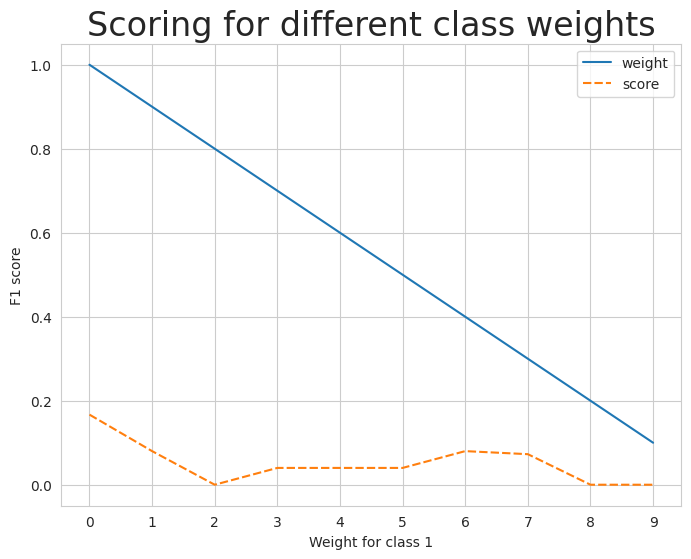

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
plt.figure(figsize=(8,6))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(data=(weigh_data['weight'], weigh_data['score']))
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks(range(len(weigh_data['weight'])))
plt.title('Scoring for different class weights', fontsize=24)

# XGBoost

In [ ]:
xgb_model = XGBRegressor()

xgb_model.fit(train_features, train_labels)
xgb_pred = torch.tensor(xgb_model.predict(test_features))

rounded_xgb_pred = abs(xgb_pred.round())
print("-- XGBoost with Standard Data --\n")
print(f"Prediction acc: {(rounded_xgb_pred == test_labels).sum() / len(test_labels):.2%}")
print(f"F1-Score : {f1_score(test_labels, rounded_xgb_pred)}\n")
print(f"Confusion matrix: \n{confusion_matrix(test_labels, rounded_xgb_pred)}")

-- XGBoost with Standard Data --

Prediction acc: 89.92%
F1-Score : 0.5806451612903226

Confusion matrix: 
[[107   9]
 [  4   9]]


In [ ]:
#xgb_model.get_params()

In [ ]:
xgb_u = XGBRegressor()

xgb_u.fit(x_under, y_under)
xgb_under_pred = torch.tensor(xgb_u.predict(under_test_features)).round()

print("-- XGBoost with UnderSampling --\n")
print(f"Prediction acc: {(xgb_under_pred == under_test_labels).sum() / len(test_labels):.2%}")
print(f"F1-Score : {f1_score(under_test_labels, xgb_under_pred)}\n")
print(f"Confusion matrix: \n{confusion_matrix(under_test_labels, xgb_under_pred)}")

-- XGBoost with UnderSampling --

Prediction acc: 65.89%
F1-Score : 0.26666666666666666

Confusion matrix: 
[[77 41]
 [ 3  8]]


In [ ]:
#xgb_u.get_params()

# NN Training and Prediction

In [ ]:
neural = Deep(
    dim_input_features= x.shape[1],
    dim_output_classes= int(y.max().item()+1),
    ).to(device)

In [ ]:
neural.fit(graph.features, graph.labels, graph.idx_train, graph.idx_test, args.reg_epochs)

Training : 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=0.4]


tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]], grad_fn=<SigmoidBackward0>)

In [ ]:
neural_pred = neural(graph.features)

In [ ]:
test_nodes = list(graph.idx_val) + list(graph.idx_test)

In [ ]:
print("-- Neural Net --")
correct = (neural_pred.argmax(1)[test_nodes] == y[test_nodes]).sum()
acc = correct / len(test_nodes)

print(f"NN Acc: {acc.item():.2%}")
print(f"F1-Score : {f1_score(y[test_nodes], neural_pred.argmax(1)[test_nodes])}\n")
confusion_matrix(y[test_nodes], neural_pred.argmax(1)[test_nodes])

-- Neural Net --
NN Acc: 91.15%
F1-Score : 0.0



array([[175,   0],
       [ 17,   0]])

# GCN Training and Prediction

In [ ]:
graph.edge_index = edge_index

In [ ]:
gcn = GCN(
    dim_input_features= x.shape[1],
    dim_output_classes= int(y.max().item()+1),
    num_hidden_layers=args.hidden_layers,
    device=device,
    lr=args.model_lr,
    dropout=args.dropout,
    weight_decay=args.weight_decay,
    name=f"gcn").to(device)

In [ ]:
gcn.fit(graph.features, graph.edge_index, graph.labels, graph.idx_train, graph.idx_test, args.reg_epochs)

Training gcn: 100%|██████████| 100/100 [00:01<00:00, 52.29it/s, loss=0.13]


tensor([[-1.6942e-02, -4.0864e+00],
        [-3.3379e-06, -1.2601e+01],
        [-2.6226e-06, -1.2835e+01],
        ...,
        [-5.2452e-06, -1.2154e+01],
        [-3.0011e-01, -1.3499e+00],
        [-2.0425e-03, -6.1946e+00]], grad_fn=<SqueezeBackward0>)

In [ ]:
gcn_pred = gcn(graph.features, graph.edge_index)

In [ ]:
test_nodes = list(graph.idx_val) + list(graph.idx_test)

In [ ]:
print("-- Baseline GCN --")
correct = (gcn_pred.argmax(1)[test_nodes] == y[test_nodes]).sum()
acc = correct / len(test_nodes)

print(f"GCN Acc: {acc.item():.2%}")
print(f"F1-Score : {f1_score(y[test_nodes], gcn_pred.argmax(1)[test_nodes])}\n")
confusion_matrix(y[test_nodes], gcn_pred.argmax(1)[test_nodes])

-- Baseline GCN --
GCN Acc: 89.06%
F1-Score : 0.15999999999999998



array([[169,   6],
       [ 15,   2]])

In [ ]:
cs = CorrectAndSmooth(num_correction_layers=50, correction_alpha=1.0,
                        num_smoothing_layers=50, smoothing_alpha=0.8,
                        autoscale=False, scale=20.)

In [ ]:
train_mask = torch.zeros((graph.number_of_nodes()))
train_mask[graph.idx_train] = 1

idx_train_mask = []
for i in range(len(train_mask)):
  if train_mask[i] > 0.:
    idx_train_mask.append(i)

idx_train_mask = torch.IntTensor(idx_train_mask)

In [ ]:
new_cs_preds = cs.correct(gcn_pred, y[idx_train_mask], idx_train_mask, edge_index)
new_cs_preds = cs.smooth(new_cs_preds, y[idx_train_mask], idx_train_mask, edge_index)

#gcn_cs_pred = (gcn.cs.forward(gcn_pred, y[graph.idx_train], train_mask, edge_index))

In [ ]:
gcn_cs_pred = new_cs_preds.argmax(axis=1)

In [ ]:

print("  -- GCN_CS --  ")
correct = (gcn_cs_pred[test_nodes] == y[test_nodes]).sum()
acc = correct / len(test_nodes)

print(f"     {acc.item():.2%}")
print(f"F1-Score : {f1_score(y[test_nodes], gcn_cs_pred[test_nodes])}\n")
confusion_matrix(y[test_nodes], gcn_cs_pred[test_nodes])


  -- GCN_CS --  
     89.06%
F1-Score : 0.08695652173913045



array([[170,   5],
       [ 16,   1]])

# RF SHAP Analysis



In [ ]:
explainer = shap.Explainer(rf.predict, df[num_cols].iloc[test_index])
shap_values = explainer(df[num_cols].iloc[test_index], max_evals=3000)

PermutationExplainer explainer: 130it [06:35,  3.09s/it]


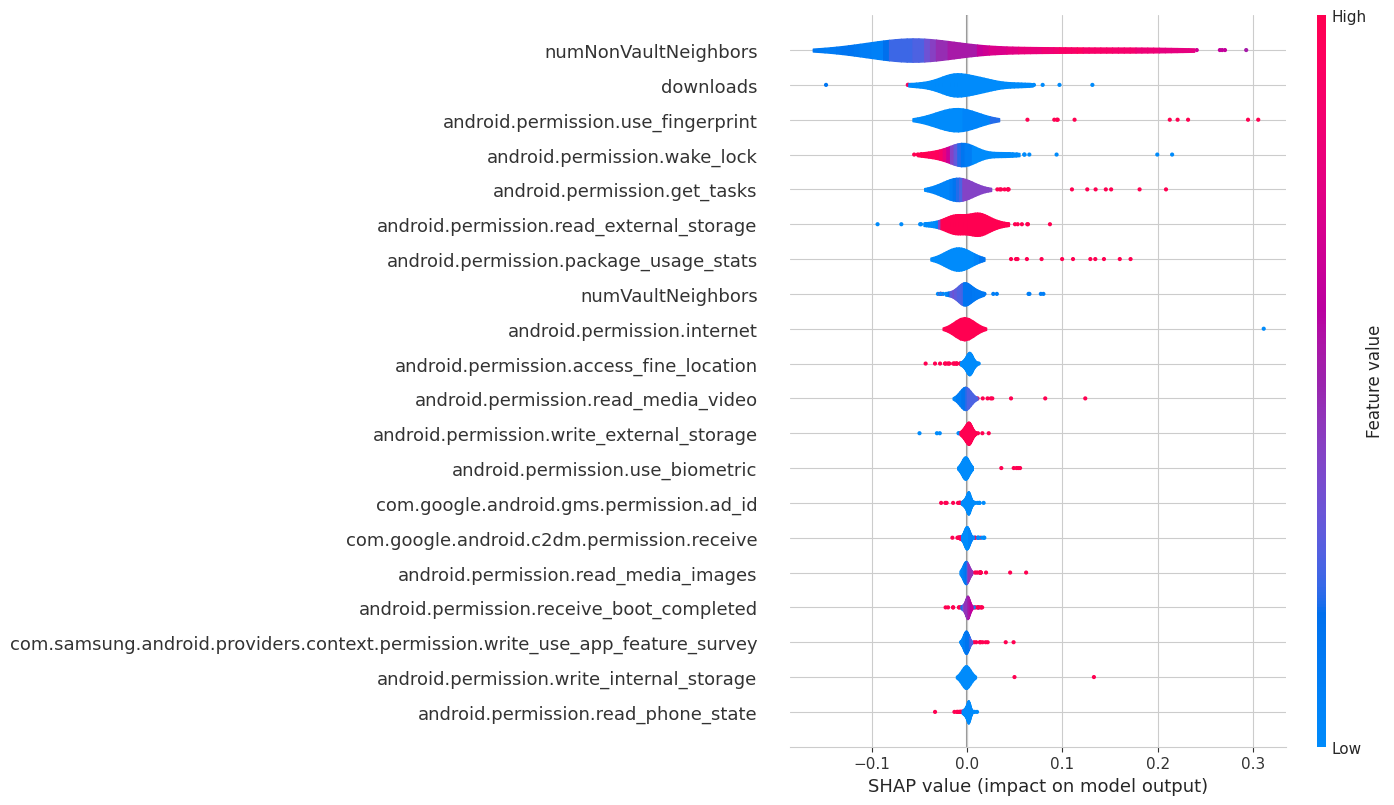

In [ ]:
shap.initjs()
shap.plots.violin(shap_values)

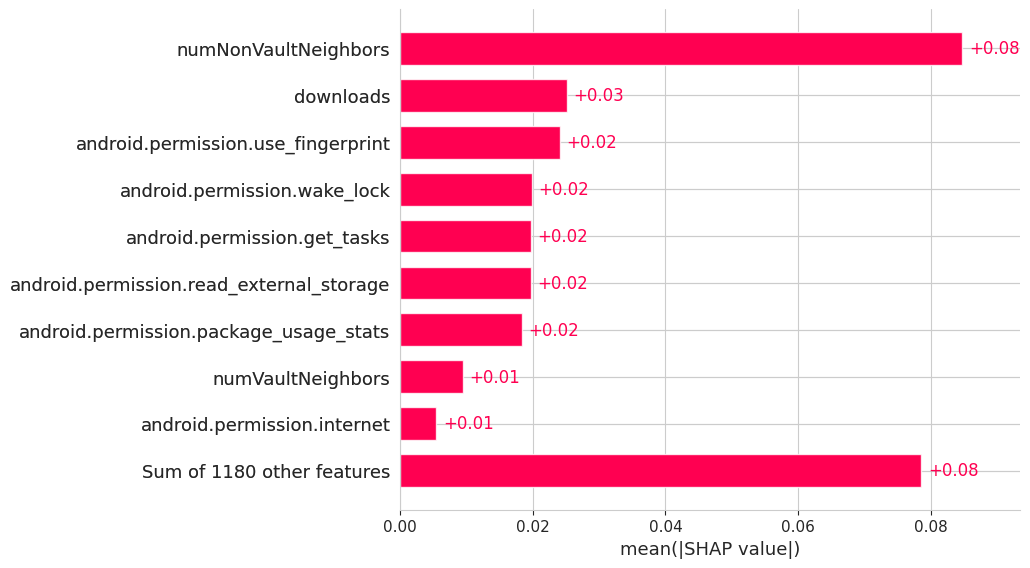

In [ ]:
shap.plots.bar(shap_values)

# XGB SHAP Analysis



In [ ]:
explainer = shap.Explainer(xgb_model.predict, df[num_cols].iloc[test_index])
shap_values = explainer(df[num_cols].iloc[test_index], max_evals=3000)

PermutationExplainer explainer: 130it [08:03,  3.81s/it]


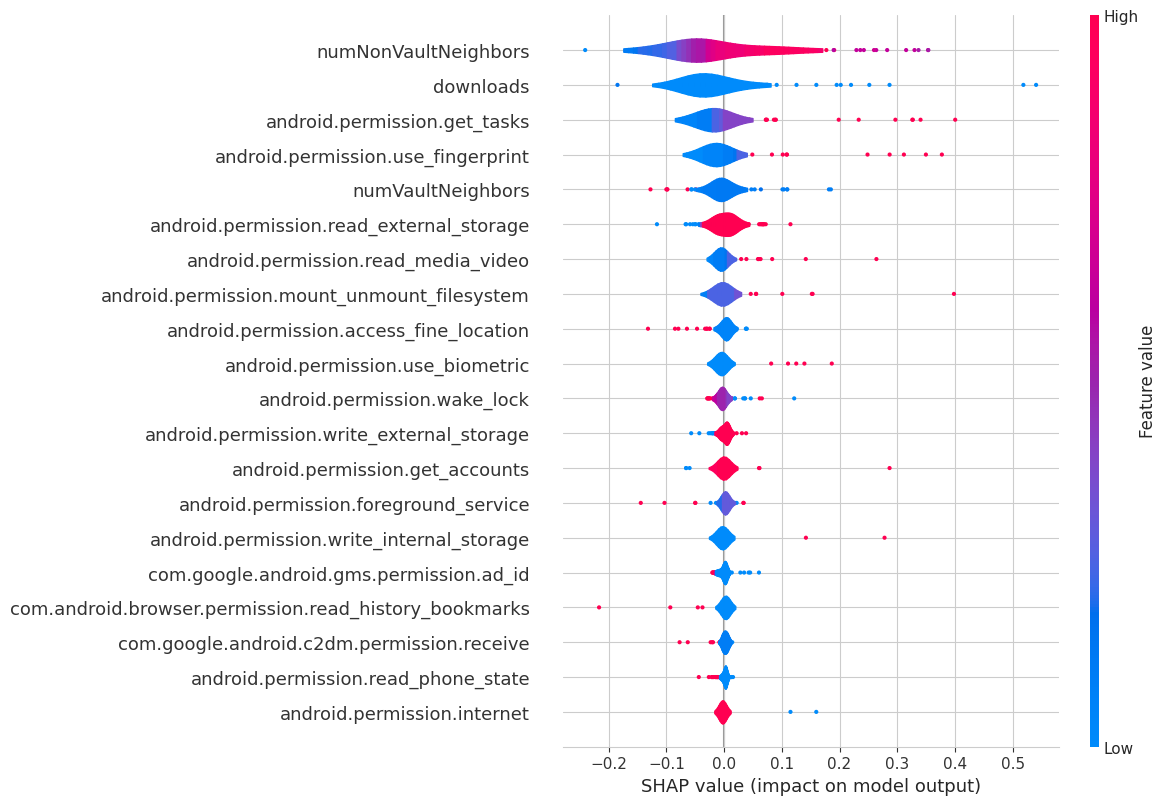

In [ ]:
shap.initjs()
shap.plots.violin(shap_values)

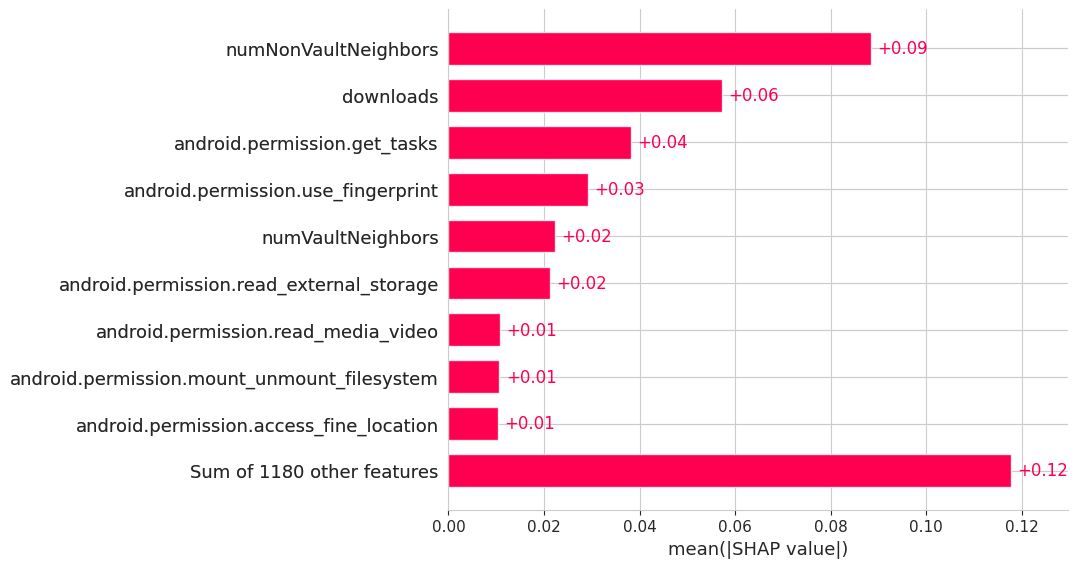

In [ ]:
shap.plots.bar(shap_values)

# GNNExplainer

In [ ]:
explainer = Explainer(
    model=gcn,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

In [ ]:
explanation = explainer(graph.features, graph.edge_index)

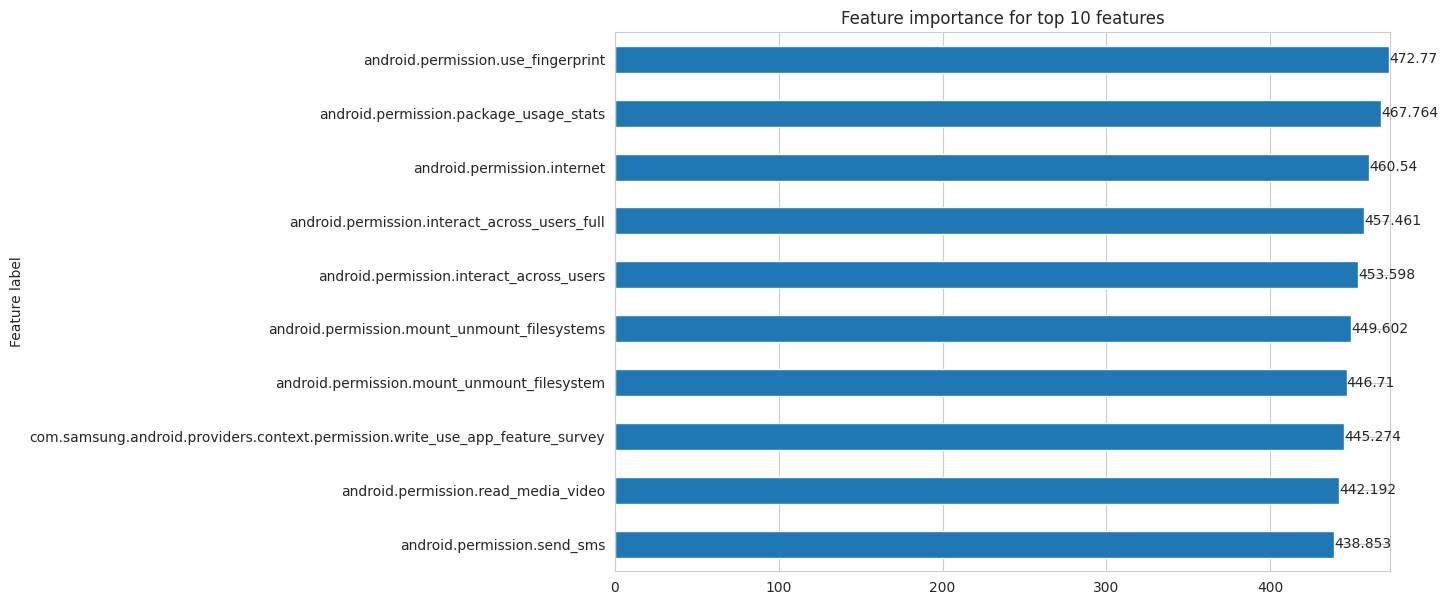

In [ ]:
explanation.visualize_feature_importance(top_k=10, feat_labels=num_cols)